In [1]:
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, rand
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline

os.environ['SPARK_HOME'] = "/home/hadoop/spark"
sys.path.insert(0, "/home/hadoop/spark/python")
sys.path.insert(0, "/home/hadoop/spark/python/lib/py4j-0.10.9.7-src.zip") 
sys.path.insert(0, "/home/hadoop/spark/python/lib/pyspark.zip")

spark = SparkSession.builder \
    .appName("Analisis_y_RandomForest") \
    .master("yarn") \
    .config("spark.executor.memory", "4g") \
    .config("spark.executor.cores", "2") \
    .config("spark.yarn.executor.memoryOverhead", "1024m") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

df = spark.read.parquet("/trafico_clean")
print(f"✅ Datos cargados. Total registros: {df.count():,}")

25/11/22 00:01:08 WARN SparkConf: The configuration key 'spark.yarn.executor.memoryOverhead' has been deprecated as of Spark 2.3 and may be removed in the future. Please use the new key 'spark.executor.memoryOverhead' instead.
25/11/22 00:01:08 WARN SparkConf: The configuration key 'spark.yarn.executor.memoryOverhead' has been deprecated as of Spark 2.3 and may be removed in the future. Please use the new key 'spark.executor.memoryOverhead' instead.
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/11/22 00:01:08 WARN SparkConf: The configuration key 'spark.yarn.executor.memoryOverhead' has been deprecated as of Spark 2.3 and may be removed in the future. Please use the new key 'spark.executor.memoryOverhead' instead.
25/11/22 00:01:09 WARN SparkConf: The configuration key 'spark.yarn.executor.memoryOverhead' has been deprecated as of Spark 2.3 and may be removed in the future. Please use the new key 'sp

✅ Datos cargados. Total registros: 16,173,222


Distribución de clases...


/tmp/ipykernel_254045/1873248177.py:7: FutureWarning:                           

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="count", y="Label", data=class_dist, palette="viridis")


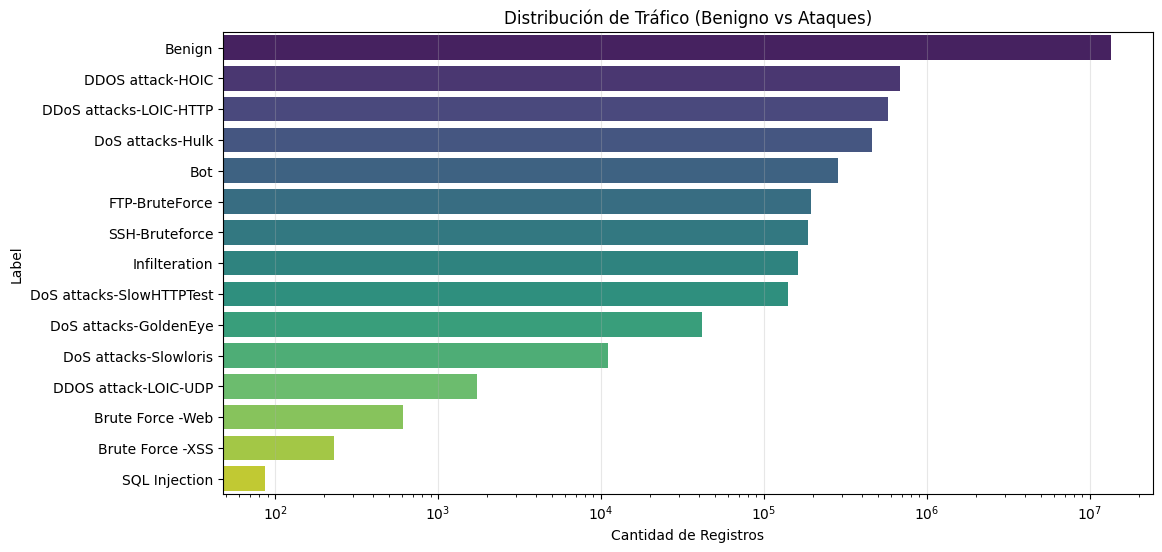

                       Label     count
0                     Benign  13425831
1           DDOS attack-HOIC    686012
2     DDoS attacks-LOIC-HTTP    576191
3           DoS attacks-Hulk    461912
4                        Bot    286191
5             FTP-BruteForce    193354
6             SSH-Bruteforce    187589
7              Infilteration    161096
8   DoS attacks-SlowHTTPTest    139890
9      DoS attacks-GoldenEye     41508
10     DoS attacks-Slowloris     10990
11      DDOS attack-LOIC-UDP      1730
12          Brute Force -Web       611
13          Brute Force -XSS       230
14             SQL Injection        87


In [5]:
print("Distribución de clases...")
#agrupar
class_dist = df.groupBy("Label").count().orderBy("count", ascending=False).toPandas()

# Gráfico de Barras
plt.figure(figsize=(12, 6))
sns.barplot(x="count", y="Label", data=class_dist, palette="viridis")
plt.title("Distribución de Tráfico (Benigno vs Ataques)")
plt.xlabel("Cantidad de Registros")
plt.xscale("log") 
plt.grid(axis="x", alpha=0.3)
plt.show()

print(class_dist)

⚡ Iniciando modo TURBO para Matriz de Correlación...
    ⬇️  Descargando muestra rápida (Head 20k)...


25/11/22 00:02:33 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
                                                                                

    ✅ Muestra descargada: 20000 filas.
    🧮 Calculando correlaciones...


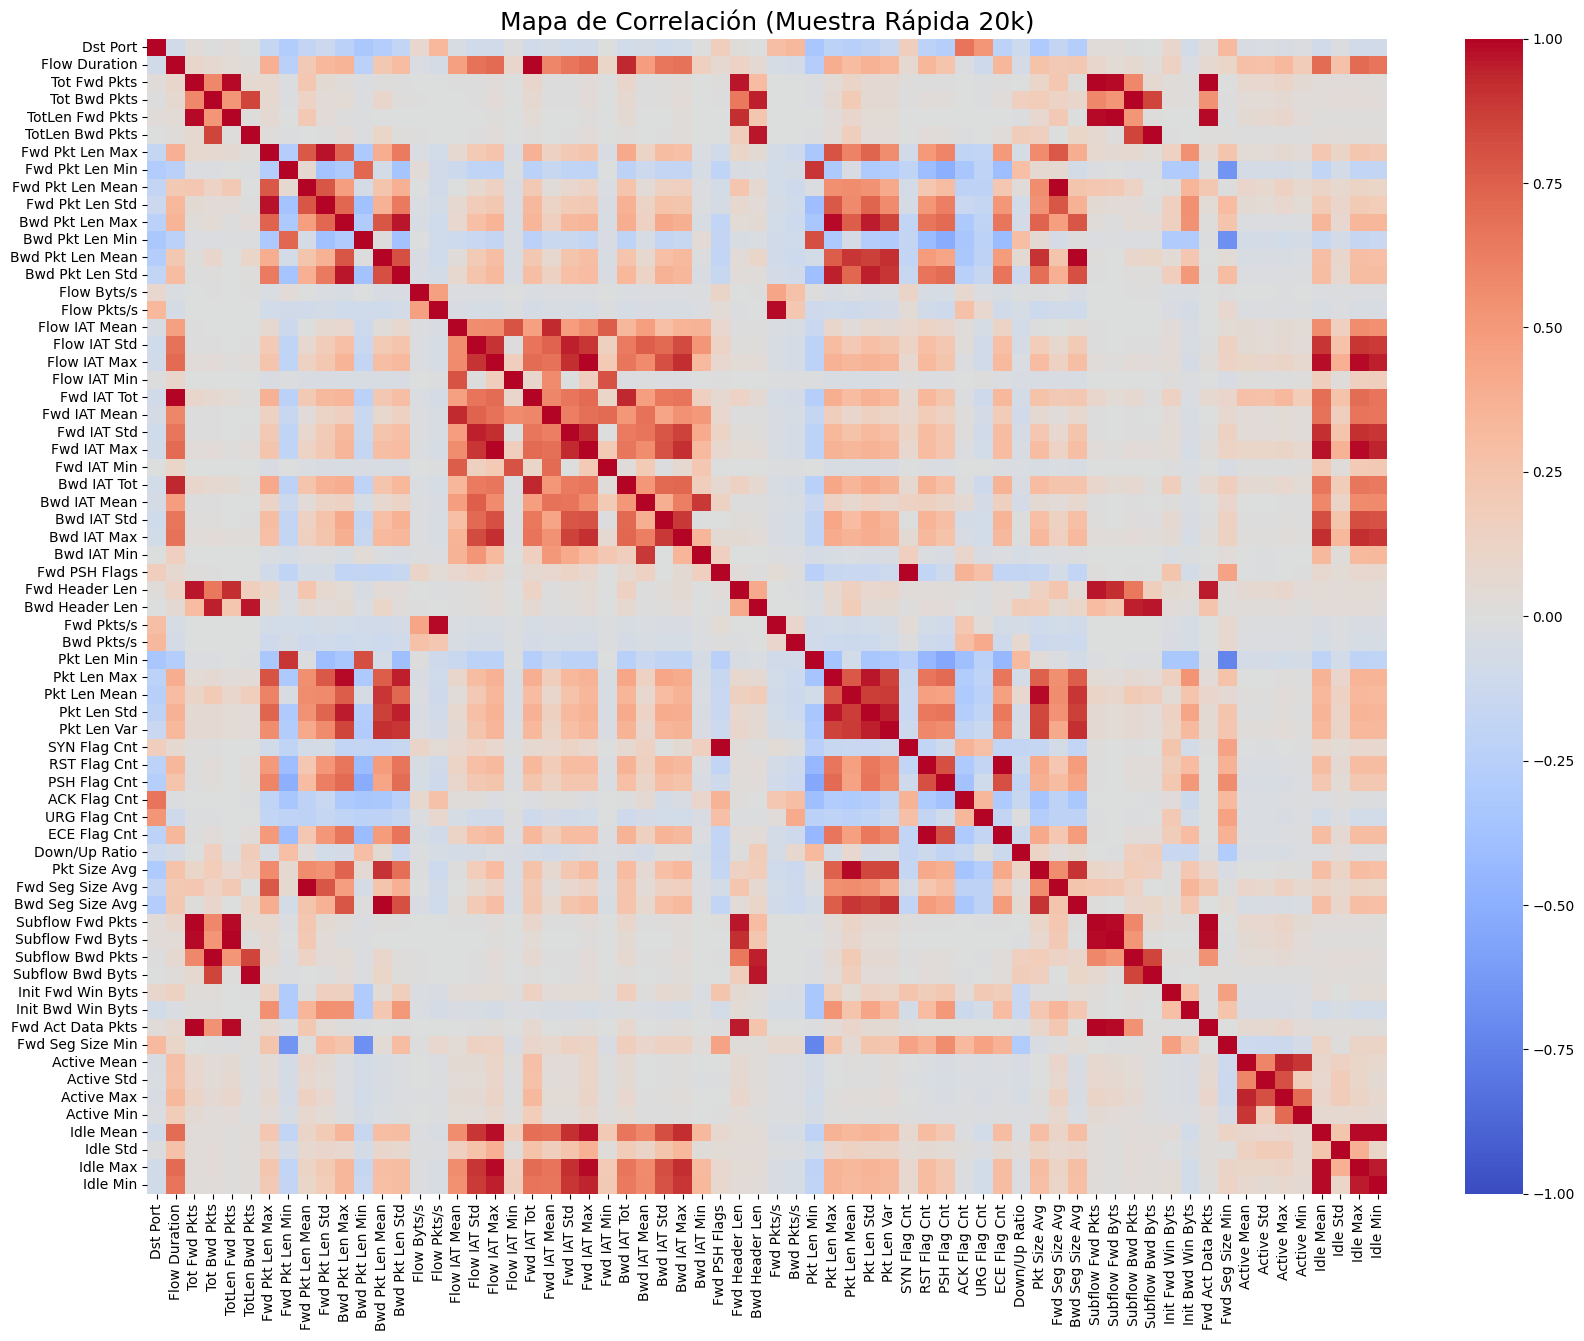

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

print("⚡ Iniciando modo TURBO para Matriz de Correlación...")

# 1. Seleccionar columnas numéricas
cols_numericas = [c for c in df.columns if c != "Label"]

# 2. TRUCO DE VELOCIDAD:
# Quitamos el .orderBy(rand()). 
# Simplemente tomamos los primeros datos que encontremos.
# Esto evita el "Shuffle" y el uso de red. Es casi instantáneo.
print("    ⬇️  Descargando muestra rápida (Head 20k)...")

df_sample = df.select(cols_numericas) \
              .limit(20000) \
              .toPandas()

print(f"    ✅ Muestra descargada: {len(df_sample)} filas.")

# 3. Calcular y Graficar (Pandas)
print("    🧮 Calculando correlaciones...")
corr_matrix = df_sample.corr()

plt.figure(figsize=(20, 15))
sns.heatmap(
    corr_matrix, 
    annot=False, 
    cmap="coolwarm", 
    vmin=-1, vmax=1
)
plt.title("Mapa de Correlación (Muestra Rápida 20k)", fontsize=18)
plt.show()